In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Modeling Exercises

In [2]:
# pull in data
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
# check summary statistics for amount column
df.Amount.describe()

count    790458.000000
mean          2.996174
std           4.751901
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max          20.000000
Name: Amount, dtype: float64

In [4]:
# check value counts for amount column
df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [5]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
# drop unnecessary columns
df.drop(columns=['Customer_Id', 'Invoice_Id', 'Subscription_Type'], inplace=True)
df.head(2)

,Month_Invoiced,Amount
0,2014-01-31,0.0
1,2014-01-31,10.0


In [7]:
# rename columns
df = df.rename(columns={'Month_Invoiced': 'bill_date', 'Amount':'amount'})
df.head(2)

,bill_date,amount
0,2014-01-31,0.0
1,2014-01-31,10.0


In [8]:
# change Month_Invoiced column to DataTime 
df.bill_date = pd.to_datetime(df.bill_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   bill_date  790458 non-null  datetime64[ns]
 1   amount     790458 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 MB


In [9]:
# set bill_date column as index and sort values
df = df.set_index('bill_date').sort_index()
df.head(2)

,amount
bill_date,
2014-01-31,0.0
2014-01-31,10.0


In [10]:
# check range of data
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [11]:
# sum up the amount of each month's sales
df = df.resample('M').amount.sum()
df.shape

(48,)

## Exercise 1

Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [12]:
# check data
df.head()

bill_date
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: amount, dtype: float64

<AxesSubplot:xlabel='bill_date'>

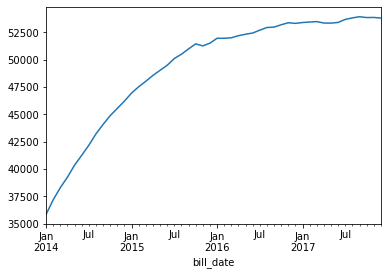

In [13]:
# plot data
df.plot()

In [21]:
# split data 50/30/20
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = pd.DataFrame(df[: train_size])
validate = pd.DataFrame(df[train_size : validate_end_index])
test = pd.DataFrame(df[validate_end_index : ])

In [22]:
# check that the split dataframes add up to the same amount of observations as the original df
train.shape[0] + validate.shape[0] + test.shape[0] == df.shape[0]

True

In [23]:
# check that the dates are successive
print(pd.concat([train.tail(1), validate.head(1)]))
print(pd.concat([validate.tail(1), test.head(1)]))

             amount
bill_date          
2015-12-31  51505.0
2016-01-31  51955.0
             amount
bill_date          
2017-02-28  53440.0
2017-03-31  53480.0


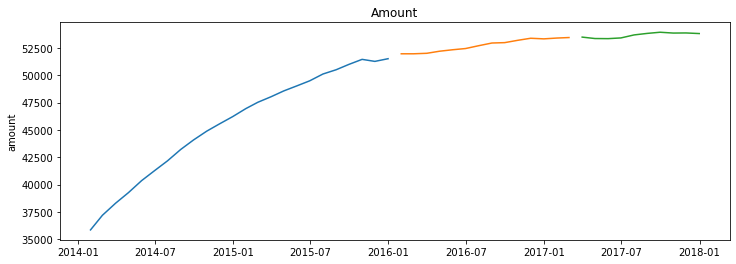

In [29]:
# plot train, validate, and test
plt.figure(figsize=(12,4))
plt.plot(train.amount)
plt.plot(validate.amount)
plt.plot(test.amount)
plt.ylabel('amount')
plt.title('Amount')
plt.show()

## Exercise 2

Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.

In [47]:
# create functions to use

# compute rmse to evaluate model
def evaluate(train_set, validate_set, target_var):
    train_rmse = round(sqrt(mean_squared_error(train_set[target_var], yhat_df[target_var])), 0)
    validate_rmse = round(sqrt(mean_squared_error(validate_set[target_var], yhat_df[target_var])), 0)
    return rmse


# plot original and predicted values
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    

# create df object to append to
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# append evaluations to a df for comparison
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Predict Using Last Observed Value

In [33]:
# create yhat of last value in train to compare validate to
amount = train['amount'][-1:][0]

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)

,amount
bill_date,
2016-01-31,51505.0
2016-02-29,51505.0


amount -- RMSE: 1343


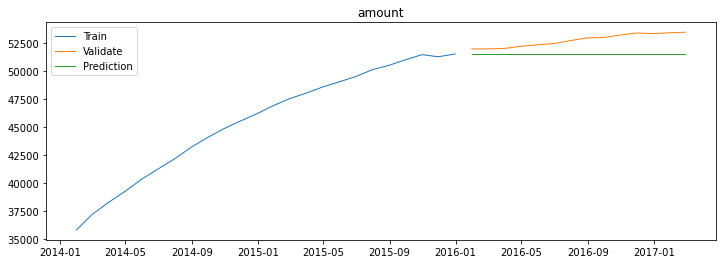

In [48]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [49]:
# evaluate model and add metrics to df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


### Predict Using Simple Average

In [51]:
# use a function to make predictions using the mean of the train dataset
amount = round(train['amount'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'amount': [amount]}, 
                           index = validate.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head(2)

,amount
bill_date,
2016-01-31,45568.54
2016-02-29,45568.54


amount -- RMSE: 7181


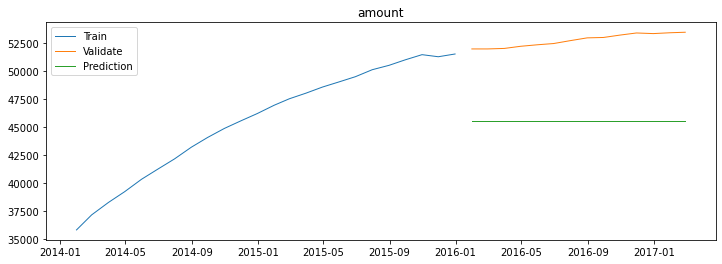

In [52]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [53]:
# evaluate model and add metrics to df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


### Predict Using Moving Average

In [60]:
# create a rolling period of 2 months
period = 2

amount = train['amount'].rolling(period).mean().iloc[-1]

# make predictions
yhat_df = make_predictions()
yhat_df.head(3)

,amount
bill_date,
2016-01-31,51382.5
2016-02-29,51382.5
2016-03-31,51382.5


amount -- RMSE: 1455


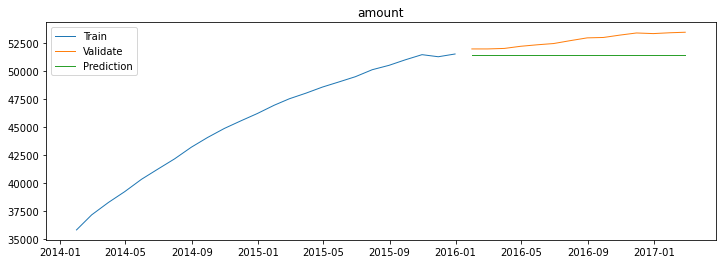

In [61]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(col)

In [62]:
# evaluate model and add metrics to df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'moving_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,moving_average,amount,1455.0


### Predict Using Holt's Linear Trend

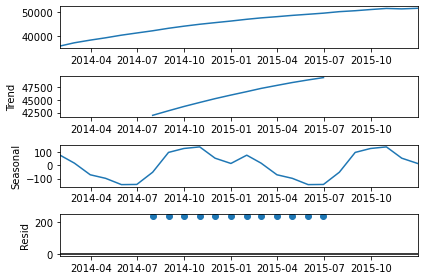

In [71]:
# check seasonal decomposition
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
None

In [ ]:

for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)